In [1]:
# <examples/doc_model_two_components.py>
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt
from lmfit import Model
from lmfit.models import PowerLawModel, ExponentialModel, GaussianModel
from lib.to_precision import to_precision
import lmfit
from sympy import *
import sympy
from sympy.solvers import solve
from sympy import Symbol
import math
import datetime
from ipywidgets import interact, FloatText, IntText, fixed, Text
now = lambda: str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").split(".")[0]
import inspect
import sympy

In [2]:
def get_Latex_Func(func):
    if func == None:
        return ""
    # Get the source code of the function
    source_lines = inspect.getsource(func).split('\n')

    # Find the return statement
    return_line = [line for line in source_lines if 'return' in line][0]

    # Extract the expression after 'return'
    expr = return_line.split('return')[1].strip()
    
    tatex_func = sympy.latex(sympy.sympify(expr))
    strg = (
        "\\begin{align} \n \t f(x) = " + tatex_func + "\n" + "\end{align} \n"
    )
    return strg


def save_data_to_file(filename='data.pkl'):
    # Dictionary für Parameter-Werte erstellen
    data_dict = {"x":Daten.get_x(),"xerr":Daten.get_xerr(),"y":Daten.get_y(),"yerr":Daten.get_yerr(),"XName":Daten.get_XName(),"YName":Daten.get_YName()}
    # Konvertiere alle Numpy-Arrays im Dictionary in Listen
    # dict_serializable = {key: value.tolist() if isinstance(value, np.ndarray) else value 
    #                      for key, value in data_dict.items()}
    # __x = []
    # __y = []
    # __xerr = 0
    # __yerr = 0
    # __XName = "x"
    # __YName = "y"
    # __FileName = "dataset_1"

    # Parameter als JSON-Datei speichern
    with open(filename, 'wb') as f:
        pickle.dump(data_dict, f)
    print(f"Daten wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_data_from_file(filename='params.pkl'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f)
    
    # # Konvertiere Listen zurück in Numpy-Arrays
    # data_dict= {key: np.array(value) if isinstance(value, list) else value
    #                     for key, value in dict_with_arrays.items()}

    # Geladene Werte in die Parameter setzen
    Daten.set_x(data_dict.get("x"))
    Daten.set_xerr(data_dict.get("xerr"))
    Daten.set_y(data_dict.get("y"))
    Daten.set_yerr(data_dict.get("yerr"))
    Daten.set_XName(data_dict.get("XName"))
    Daten.set_YName(data_dict.get("YName"))

    print(f"Daten wurden aus {filename} geladen.")

def finish(x,y,result, string, y_err, yLabel, xLabel):
    fig = plt.figure(figsize=(9,6), dpi=80)
    dynamic_resolution_array = np.arange(min(x),max(x), 0.001*abs(max(x)-min(x)))
    #plt.plot(x, y, 'skyblue')
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.errorbar(
        y = y, 
        x = x, 
        yerr = y_err,
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, label = r'Werte'
        ) #xerr = x_err, yerr = y_err, 
    plt.legend(loc='best')

    plt.ylabel(yLabel, fontsize=20)
    plt.xlabel(xLabel, fontsize=20)

    plt.legend(fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    string += Daten.get_Version()
    fig.savefig(string + "_Fit.pdf")
    plt.show()

    string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{Fits/" + string + "_Fit.pdf} \n" \
        + "\t\\caption{"+str(string)+", Fit} \n \t\\label{fig:"+str(string)+", Fit} \n\end{figure}"
    print(string_fig)

    text_file = open(string+"_params"+".tex", "w+", encoding="utf-8")
    string_fig += "\n \\\\ \n" 
    string_fig += get_Latex_Func(Daten.get_func())
    string_fig += table_of_params(result)
    text_file.write(string_fig)
    text_file.close()


def table_of_params(result_of_fit):
    sig_num = 3
    string = "" + (
        "\\begin{table}[ht] \n"
        "\centering \n") +"\caption{" + str(Daten.get_FileName()).replace("_", " ") +", Fit Parameter Tabelle} \n"  + (
        "\label{tab:my-table}\n"
        "\\begin{tabular}{|l|c|}\n" 
        "\hline\n"
        "Parameter Name\t&\tWert \\\\ \hline\n"
    )
    for i in result_of_fit.params:
        str_param_val = f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}" 
        str_param_std = f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}" 
        string += (
            str(i) + "\t&\t" +
            str_param_val +
            ("" if "." in str_param_val  else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num+2 -len(f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}"))) +
            " \\pm "+ 
            str_param_std +
            ("" if "." in str_param_std else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num+2-len(f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}"))) +
            "\\\\ \hline\n"
        )
    string += (
        "\end{tabular} \n"
        "\end{table}"
    )
    return string


class Data:
    __x = []
    __y = []
    __xerr = 0
    __yerr = 0
    __XName = "x"
    __YName = "y"
    __FileName = "dataset_1",
    __Version = ""
    __pars = None
    __func = None
    __fitres = None

    def set_res(self, x):
        self.__fitres = x
        return
    def get_res(self):
        return self.__fitres
    
    def set_func(self, x):
        self.__func = x
        return
    def get_func(self):
        return self.__func

    def set_x(self, x):
        self.__x = x
        return  
    def set_y(self, x):
        self.__y = x
        return  
    def set_yerr(self, x):
        self.__yerr = x
        return  
    def set_xerr(self, x):
        self.__xerr = x
        return  
    
    def get_x(self):
        return self.__x
    def get_y(self):
        return self.__y
    def get_xerr(self):
        return self.__xerr
    def get_yerr(self):
        return self.__yerr
    
    def set_XName(self, x):
        self.__XName = rf"{x}"
        return
    def set_YName(self, x):
        self.__YName = rf"{x}"
        return
    def get_XName(self):
        return self.__XName
    def get_YName(self):
        return self.__YName
    
    def get_FileName(self):
        return self.__FileName
    
    def set_FileName(self, x):
        self.__FileName = f"{x}"
        return
    def set_Version(self, x):
        self.__Version = f"{x}"
        return
    def get_Version(self):
        return self.__Version
    
    def get_pars(self):
        return self.__pars
    def set_pars(self,x):
        self.__pars = x
        return
    

def table_of_params_data(result_of_fit, Daten=Data(), sig_num = 3):
    string = "" + (
        "\\begin{table}[ht] \n"
        "\t\centering \n") +"\t\caption{" + str(Daten.get_FileName()).replace("_", " ") +", Fit Parameter Tabelle} \n"  + (
        "\t\label{tab: " + str(Daten.get_FileName()).replace("_", " ") +", Fit Parameter Tabelle}\n"
        "\t\\begin{tabular}{|l|c|}\n" 
        "\t\t\hline\n"
        "\t\tParameter Name\t&\tWert \\\\ \hline\n"
    )
    for i in result_of_fit.params:
        str_param_val = f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}" 
        str_param_std = f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}" 
        string += (
            "\t\t" + str(i) + "\t&\t" +
            str_param_val +
            ("" if "." in str_param_val  else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num+2 -len(f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}"))) +
            " $\\pm$ "+ 
            str_param_std +
            ("" if "." in str_param_std else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num+2-len(f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}"))) +
            "\\\\ \hline\n"
        )
    string += (
        "\t\end{tabular} \n"
        "\end{table}"
    )
    return string

def table_of_data(Daten = Data(), sig_x = 1, sig_y = 3):
    string = "" + (
        "\\begin{table}[ht] \n"
        "\t\centering \n") +"\t\caption{" + str(Daten.get_FileName()).replace("_", " ") +", Messwerte Tabelle} \n"  + (
        "\t\label{tab: " + str(Daten.get_FileName()).replace("_", " ") +", Messwerte Tabelle}\n"
        "\t\\begin{tabular}{|c|c|}\n" 
        "\t\t\hline\n"
        f"\t\t{Daten.get_XName()} \t&\t {Daten.get_YName()}\\\\ \hline\n"
    )
    for xval, xerrval, yval, yerrval in zip(Daten.get_x(), Daten.get_xerr(), Daten.get_y(), Daten.get_yerr()):
        string += (
            f"\t\t{xval:.{sig_x}f} $\\pm$ {xerrval:.{sig_x}f} \t&\t {yval:.{sig_y}f} $\\pm$ {yerrval:.{sig_y}f} \\\\ \hline\n"
        )
    string += (
        "\t\end{tabular} \n"
        "\end{table}"
    )
    return string


def finish_data(Daten = Data(), result = None, sigx = 3, sigy = 3):
    x = Daten.get_x()
    y = Daten.get_y()
    string = Daten.get_FileName()
    y_err = Daten.get_yerr()
    yLabel = Daten.get_YName()
    xLabel = Daten.get_XName()
    
    fig = plt.figure(figsize=(9,6), dpi=80)
    dynamic_resolution_array = np.arange(min(x),max(x), 0.001*abs(max(x)-min(x)))
    #plt.plot(x, y, 'skyblue')
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.errorbar(
        y = y, 
        x = x, 
        yerr = y_err,
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, label = r'Werte'
        ) #xerr = x_err, yerr = y_err, 
    plt.legend(loc='best')

    plt.ylabel(yLabel, fontsize=20)
    plt.xlabel(xLabel, fontsize=20)

    plt.legend(fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    string += Daten.get_Version()
    fig.savefig(string + "_Fit.pdf")
    plt.show()

    string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{Fits/" + string + "_Fit.pdf} \n" \
        + "\t\\caption{"+str(string.replace("_", " "))+", Fit} \n \t\\label{fig:"+str(string.replace("_", " "))+", Fit} \n\end{figure}"
    print(string_fig)

    text_file = open(string+"_params"+".tex", "w+", encoding="utf-8")
    string_fig += "\n \n" 
    string_fig += get_Latex_Func(Daten.get_func()) + "\n \n" if get_Latex_Func(Daten.get_func()) != "" else ""
    string_fig += table_of_params_data(result, Daten, sigy) + "\n \n"
    string_fig += table_of_data(Daten, sigx, sigy) + "\n \n"
    text_file.write(string_fig)
    text_file.close()



def import_Data(Datei:str="dataset_1", x_err_bool = False, y_err_bool = False, Daten=Data(), skip_lower:str="0", skip_upper:str="0", x_name:str="x", y_name:str="y", save_bool=False,Save:int=0,Load:int=0,switch_axes:bool=False,show_plot:bool=True):
    data = np.genfromtxt(Datei+".txt", skip_header = int(skip_upper), skip_footer = int(skip_lower))
    #data = np.genfromtxt(string+".txt", skip_header = 1, skip_footer = 18)

    if x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(data[:, 3])
    elif x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(0)
    elif not x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(data[:, 2])
    elif not x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(0)
    
    Daten.set_XName(x_name)
    Daten.set_YName(y_name)
    Daten.set_FileName(Datei)

    if switch_axes:
        temp = [Daten.get_x(), Daten.get_xerr()]
        Daten.set_x(Daten.get_y())
        Daten.set_xerr(Daten.get_yerr())
        Daten.set_y(temp[0])
        Daten.set_yerr(temp[1])
        
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_data_to_file(f'{Daten.get_FileName()}_daten_{Save}.pkl')
    if Load != 0:
        # Aufruf der Funktion zum Laden
        load_data_from_file(f'{Daten.get_FileName()}_daten_{Load}.pkl')

    if show_plot:
        plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
            fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
            label = r'Werte')
        plt.legend(loc='best')
        plt.ylabel(Daten.get_YName(), fontsize=20)
        plt.xlabel(Daten.get_XName(), fontsize=20)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.tight_layout()
        if save_bool:
            plt.savefig(Datei + f"_{Load}_Plot.pdf")
            string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{bilder/" + Datei + "_Plot.pdf} \n" \
                + "\t\\caption{"+str(Datei)+", Plot_log} \n \t\\label{fig:"+str(Datei)+", Plot_log} \n\end{figure}"
            print(string_fig)

        plt.show()


# Funktion zum Speichern der Parameter in einer JSON-Datei
def save_params_to_file(params, filename='params.json'):
    # Dictionary für Parameter-Werte erstellen
    params_dict = {name: param.value for name, param in params.items()}
    
    # Parameter als JSON-Datei speichern
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
    print(f"Parameter wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_params_from_file(params, filename='params.json'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'r') as f:
        params_dict = json.load(f)

    # Geladene Werte in die Parameter setzen
    for name, value in params_dict.items():
        if name in params:
            params[name].value = value
        else:
            print(f"Warnung: Parameter {name} existiert nicht im aktuellen Modell.")

    print(f"Parameter wurden aus {filename} geladen.")

def update_model(Save:int=0, Load:int=0, **params):
    # Setze die Werte der Parameter
    for name, value in params.items():
        pars[name].value = value
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_params_to_file(pars, f'{Daten.get_FileName()}_params_{Save}.json')
        Daten.set_Version(Save)
    if Load != 0:
        load_params_from_file(pars, f'{Daten.get_FileName()}_params_{Load}.json')
        Daten.set_Version(Load)

    # Berechne Modell mit aktuellen Parametern
    x = Daten.get_x()
    x_fit = np.arange(x.min(), x.max(), (x.max() - x.min())/10000)
    y_fit = mod.eval(pars, x=x_fit)

    # Plotten der Daten und des Modells
    plt.figure(figsize=(8, 6))
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    
    plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.title('Models')
    result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
    Daten.set_pars(result)
    dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'b-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.tight_layout()
    plt.show()
    

# Mehre Dateien einlesen

In [3]:
from FFP_lib import FFP
# Daten für alle materialien einlesen und verrrechnen
lst_materialien = ["Al", "Cu", "Ge", "NaCl", "Si", "SiO2"]

name = "Rp_Rs_"
filetype = ".txt"

def func(x = None, y = None, z = None, a = None, b = None, c = None):
	return x / y

results = np.empty((6,17))
res_errors = np.empty((6,17))
for i, material in enumerate(lst_materialien):
    data = np.genfromtxt(name + material + filetype, skip_header = 1, skip_footer = 0)
    # Detektor Offset
    data[:,0] += 0.003
    data[:,2] += 0.003
    res = FFP(data = data, func = func, name = name, save = False)
    results[i,:] = res.get_res()
    res_errors[i,:] = res.get_err()

In [4]:
# Ergebnisse in die daten Klasse laden
Daten_0 = Data()
Daten_1 = Data()
Daten_2 = Data()
Daten_3 = Data()
Daten_4 = Data()
Daten_5 = Data()

Daten_lst = [Daten_0, Daten_1, Daten_2, Daten_3, Daten_4, Daten_5]

for Daten_i, result, errors, material in zip(Daten_lst, results, res_errors, lst_materialien):
    Daten_i.set_FileName(f"Rp_Rs_{material}")
    Daten_i.set_yerr(errors*3)
    Daten_i.set_y(result)
    Daten_i.set_x(np.flip(np.arange(10,95,5)))
    Daten_i.set_xerr(0.2*np.ones_like(Daten_i.get_x()))
    Daten_i.set_XName(r"Einfallswinkel $\Phi_i$ [°]")
    Daten_i.set_YName(r"$\frac{R_p}{R_s}$")


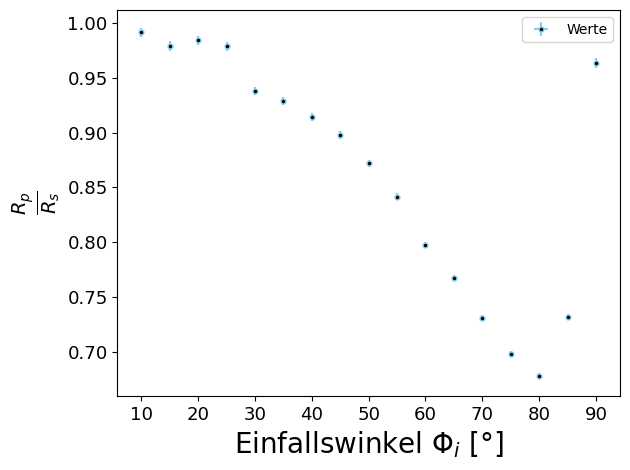

In [5]:
# Beispielwerte
plt.errorbar(y = Daten_0.get_y(), yerr = Daten_0.get_yerr(), x = Daten_0.get_x(), xerr = Daten_0.get_xerr(), \
            fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
            label = r'Werte')
plt.legend(loc='best')
plt.ylabel(Daten_0.get_YName(), fontsize=20)
plt.xlabel(Daten_0.get_XName(), fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
        

In [6]:
sigx, sigy = 1,3

print(table_of_data(Daten_0, sig_x = sigx, sig_y = sigy))

\begin{table}[ht] 
	\centering 
	\caption{Rp Rs Al, Messwerte Tabelle} 
	\label{tab: Rp Rs Al, Messwerte Tabelle}
	\begin{tabular}{|c|c|}
		\hline
		Einfallswinkel $\Phi_i$ [°] 	&	 $\frac{R_p}{R_s}$\\ \hline
		90.0 $\pm$ 0.2 	&	 0.964 $\pm$ 0.005 \\ \hline
		85.0 $\pm$ 0.2 	&	 0.732 $\pm$ 0.003 \\ \hline
		80.0 $\pm$ 0.2 	&	 0.678 $\pm$ 0.003 \\ \hline
		75.0 $\pm$ 0.2 	&	 0.697 $\pm$ 0.003 \\ \hline
		70.0 $\pm$ 0.2 	&	 0.730 $\pm$ 0.003 \\ \hline
		65.0 $\pm$ 0.2 	&	 0.767 $\pm$ 0.003 \\ \hline
		60.0 $\pm$ 0.2 	&	 0.797 $\pm$ 0.003 \\ \hline
		55.0 $\pm$ 0.2 	&	 0.841 $\pm$ 0.003 \\ \hline
		50.0 $\pm$ 0.2 	&	 0.872 $\pm$ 0.003 \\ \hline
		45.0 $\pm$ 0.2 	&	 0.898 $\pm$ 0.004 \\ \hline
		40.0 $\pm$ 0.2 	&	 0.914 $\pm$ 0.004 \\ \hline
		35.0 $\pm$ 0.2 	&	 0.929 $\pm$ 0.004 \\ \hline
		30.0 $\pm$ 0.2 	&	 0.938 $\pm$ 0.004 \\ \hline
		25.0 $\pm$ 0.2 	&	 0.979 $\pm$ 0.004 \\ \hline
		20.0 $\pm$ 0.2 	&	 0.984 $\pm$ 0.004 \\ \hline
		15.0 $\pm$ 0.2 	&	 0.979 $\pm$ 0.004 \\ \hline
		10.0 $

# Einzelne Datei einlesen

## Interactive

In [ ]:
Daten = Data()

interact(import_Data, Datei="Rp_Rs_Si", x_err_bool = False, y_err_bool = False, x_name = "Polfilter orientierung [°]", y_name = "Detektorspannung [mV]", Daten=fixed(Daten), 
         skip_lower = "0",
         skip_upper = "1",
         save_bool = False,
         switch_axes = False,
         Save=IntText(value=0,description='Daten Speichern:'), Load=IntText(value=0,description='Daten Laden:'),
         
         )# IntText(value=0, step=1)
print()

In [ ]:
print(table_of_data(Daten, sig_x = 3, sig_y = 3))

## Non Interactive

In [ ]:
Daten = Data()

import_Data(Datei="A2_Signal_110V_TimeProfile_130Latency", 
            x_err_bool = False, 
            y_err_bool = False, 
            x_name = "Zeit [ns]", y_name = "Mittleres Signal (ADC)", 
            Daten=Daten, 
            skip_lower = "0",
            skip_upper = "2",
            save_bool = False,
            Save=0, Load=0
            )

# Error Band

In [ ]:
freq_lst = [130,132,133,134]
string_fig = ""
for freq in freq_lst:
    Daten = Data()

    import_Data(Datei=f"A2_Signal_110V_TimeProfile_{freq}Latency", 
            x_err_bool = False, 
            y_err_bool = False, 
            x_name = "Zeit [ns]", y_name = "Mittleres Signal (ADC)", 
            Daten=Daten, 
            skip_lower = "0",
            skip_upper = "2",
            save_bool = False,
            Save=0, Load=0, show_plot=False
            )

    x = Daten.get_x()
    string = Daten.get_FileName()

    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.set_xlim([0, np.max(Daten.get_x())+5])
    ax.set_ylim([0, np.max(Daten.get_y())+5])
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')

    plt.fill_between(np.arange(0,26,1), 0, np.max(Daten.get_y())+5, alpha=0.2, color = "red", label = r'Messbereich, 0-25 ns')
    # plt.plot(x, y, label='Median with Error Band')
    #plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    # plt.title('Models')
    plt.tight_layout()
    string += Daten.get_Version()
    fig.savefig(string + "_Messberreich.pdf")

    string_fig += "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{bilder/" + Daten.get_FileName() + "_Messberreich.pdf} \n" \
            + "\t\\caption{"+str(Daten.get_FileName())+", Messberreich} \n \t\\label{fig:"+str(Daten.get_FileName())+", Messberreich} \n\end{figure} \n \n \n"
        
print(string_fig)

# Fitten

## Fit-Funktionen festlegen

In [7]:
from sympy import oo, Symbol, integrate, Function
def convolve(f, g, t, lower_limit=-oo, upper_limit=oo):
    tau = Symbol('__very_unlikely_name__', real=True)
    return integrate(Function(f).subs(t, tau) * Function(g).subs(t, t - tau), 
                     (tau, lower_limit, upper_limit))

def Gauss(x,sigma=1,mu=1):
    return 1/(sigma*np.sqrt(2*math.pi))*np.exp(-1/2*(x-mu/sigma)**2)

def Landau(x):
    t = Symbol('__very_unlikely_name__', real=True)
    return integrate(1/(math.pi)*np.exp(-x*np.ln(t-x*t))*np.sin(math.pi*t) ,
                     (t, 0, oo))

def Model_test(x):
    return(convolve(Gauss, Landau, x))


# Fitfunktion definieren
def Rp_Rs(x, n = 3.6 , kappa = 0.15):
    phi = x*np.pi/180
    Lambda = n**2 - kappa**2 - np.sin(phi)**2
    mu = np.sqrt(Lambda**2 + 4*n**2 * kappa**2)
    res = (mu + np.sin(phi)**2 * np.tan(phi)**2 - np.sin(phi)*np.tan(phi)*np.sqrt(2*(Lambda + mu))) / (mu + np.sin(phi)**2 * np.tan(phi)**2 + np.sin(phi)*np.tan(phi)*np.sqrt(2*(Lambda + mu)))
    return res


In [8]:
from lmfit.models import PowerLawModel, ExponentialModel, GaussianModel, Model
# import pylandau

# def plot_func(x, mpv=1, eta=1, sigma=1, A=1):
#     return pylandau.langau(x, mpv, eta, sigma, A)

def plot_func(x,a=1,b=1,c=1,d=1,e=1):
    return a*x**4+b*x**3+c*x**2+d*x+e


# Modell auswählen
mod = Model(Rp_Rs)#  +GaussianModel()# Model(plot_func)#GaussianModel(prefix = "a")+GaussianModel(prefix = "b")

pars = mod.make_params()
pars

name,value,initial value,min,max,vary
n,3.60000000,None,-inf,inf,True
kappa,0.15000000,None,-inf,inf,True


## Parameter Festlegen

In [9]:
param_widgets = {}
for param_name, param in pars.items():
    param_widgets[param_name] = FloatText(value=param.value,
                                            step=0.1,
                                            description=param_name)

# Interaktive Anzeige mit automatisch generierten Slidern
interact(update_model, Save=IntText(value=0), Load=IntText(value=0), **param_widgets)
print()

interactive(children=(IntText(value=0, description='Save'), IntText(value=0, description='Load'), FloatText(va…

## Fit speichern

In [10]:
# pars["n"].init_value = 3
# pars["kappa"].init_value = 1

weights = 1/(Daten.get_yerr())
res = mod.fit(Daten.get_y(), pars, x=Daten.get_x(),weights=weights)
finish_data(Daten, res, sigx = 1, sigy = 4)


NameError: name 'Daten' is not defined

In [ ]:
result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))

plt.figure(figsize=(8, 6))
plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
    fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
    label = r'Werte')

#plt.plot(x_fit, y_fit, label="Modell", color='red')
plt.legend()
plt.ylabel(Daten.get_YName(), fontsize=20)
plt.xlabel(Daten.get_XName(), fontsize=20)
plt.title('Models')

plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))

plt.show()

In [ ]:
Daten.get_pars()

# Mehere Fits nacheinander generieren

In [11]:
# Fitfunktion definieren
def Rp_Rs(x, n = 1.17 , kappa = 5.45):
    phi = x*np.pi/180
    Lambda = n**2 - kappa**2 - np.sin(phi)**2
    mu = np.sqrt(Lambda**2 + 4*n**2 * kappa**2)
    res = (mu + np.sin(phi)**2 * np.tan(phi)**2 - np.sin(phi)*np.tan(phi)*np.sqrt(2*(Lambda + mu))) / (mu + np.sin(phi)**2 * np.tan(phi)**2 + np.sin(phi)*np.tan(phi)*np.sqrt(2*(Lambda + mu)))
    return res

# Modell auswählen
mod = Model(Rp_Rs)#  +GaussianModel()# Model(plot_func)#GaussianModel(prefix = "a")+GaussianModel(prefix = "b")

pars = mod.make_params()
pars

name,value,initial value,min,max,vary
n,1.17000000,None,-inf,inf,True
kappa,5.45000000,None,-inf,inf,True


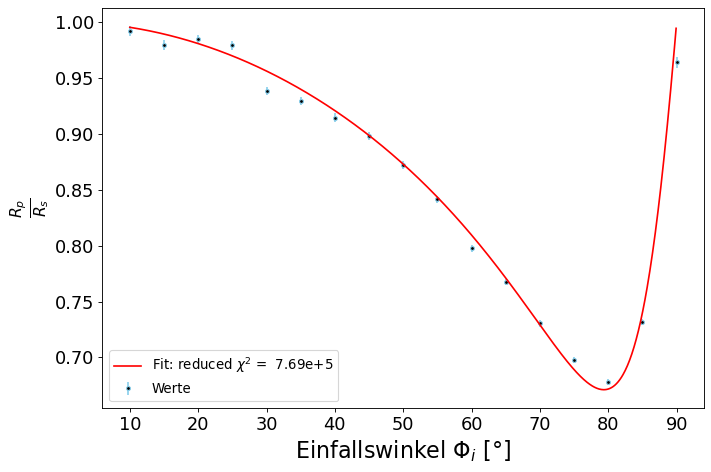

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/Rp_Rs_Al_Fit.pdf} 
	\caption{Rp Rs Al, Fit} 
 	\label{fig:Rp Rs Al, Fit} 
\end{figure}


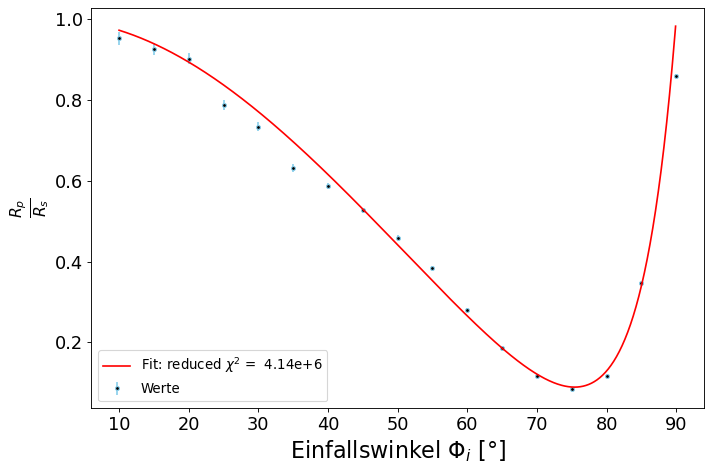

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/Rp_Rs_Cu_Fit.pdf} 
	\caption{Rp Rs Cu, Fit} 
 	\label{fig:Rp Rs Cu, Fit} 
\end{figure}


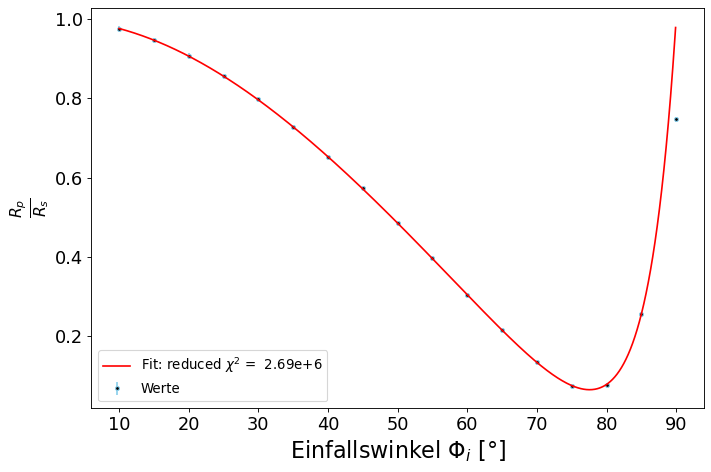

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/Rp_Rs_Ge_Fit.pdf} 
	\caption{Rp Rs Ge, Fit} 
 	\label{fig:Rp Rs Ge, Fit} 
\end{figure}


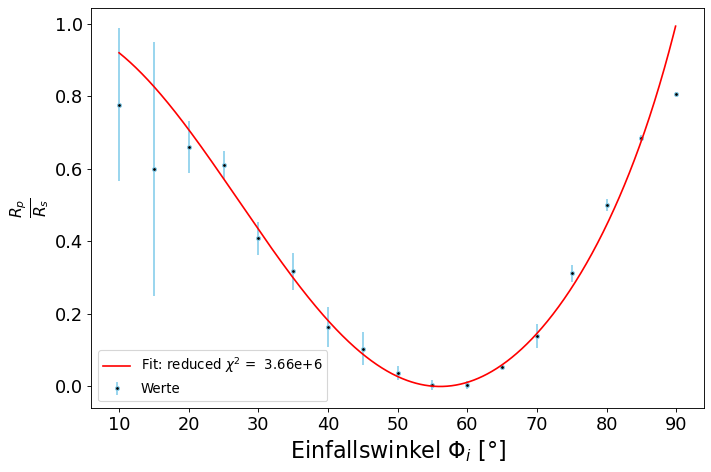

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/Rp_Rs_NaCl_Fit.pdf} 
	\caption{Rp Rs NaCl, Fit} 
 	\label{fig:Rp Rs NaCl, Fit} 
\end{figure}


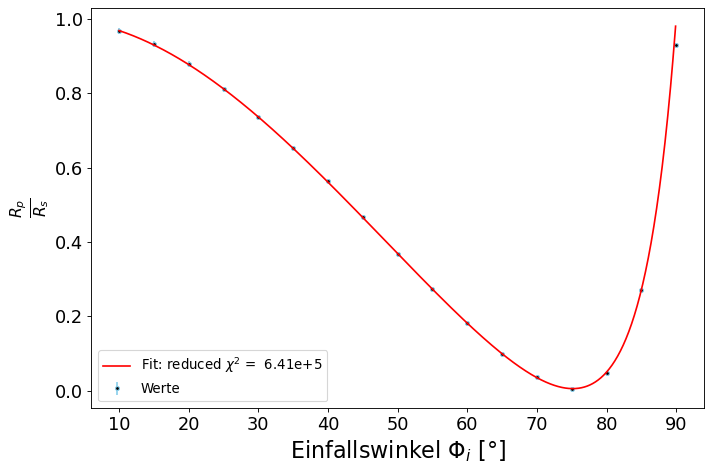

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/Rp_Rs_Si_Fit.pdf} 
	\caption{Rp Rs Si, Fit} 
 	\label{fig:Rp Rs Si, Fit} 
\end{figure}


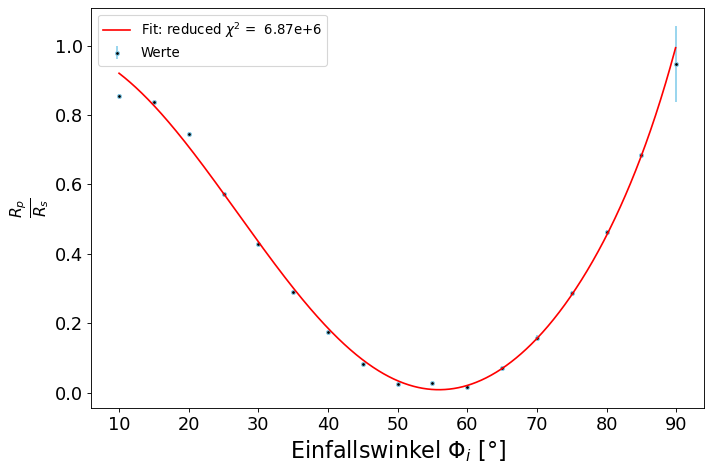

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/Rp_Rs_SiO2_Fit.pdf} 
	\caption{Rp Rs SiO2, Fit} 
 	\label{fig:Rp Rs SiO2, Fit} 
\end{figure}


In [22]:
materials = ["Al", "Cu", "Ge", "NaCl", "Si", "SiO2"]
Ns = [1.17, 0.399, 4.077, 1.483, 3.821, 1.4]
Kappas = [5.46, 1.921, 2.069, 0.014, 0.131, 0.14]
for Daten_i, N, Kappa, res_i in zip(Daten_lst , Ns, Kappas, results):
    pars["n"].init_value = N
    pars["kappa"].init_value = Kappa
    weights = 1/(Daten_i.get_yerr())**2
    Daten_i.set_res(mod.fit(Daten_i.get_y(), pars, x=Daten_i.get_x(),weights=weights))
    finish_data(Daten_i, Daten_i.get_res(), sigx, sigy)


In [21]:
def table_of_data_ffp(ffpdadta, Daten = Data(), sig_x = 1, sig_y = 3, sig_ffp1 = 3, sig_ffp2 = 3):
    string = "" + (
        "\\begin{table}[ht] \n"
        "\t\centering \n") +"\t\caption{" + str(Daten.get_FileName()).replace("_", " ") +", Messwerte Tabelle} \n"  + (
        "\t\label{tab: " + str(Daten.get_FileName()).replace("_", " ") +", Messwerte Tabelle}\n"
        "\t\\begin{tabular}{|c|c|c|c|}\n" 
        "\t\t\hline\n"
        f"\t\t{Daten.get_XName()} \t&\t Parallel [V] \t&\t Senkrecht [V] \t&\t {Daten.get_YName()}\\\\ \hline\n"
    )
    for i, xval, xerrval, yval, yerrval in zip(range(len(Daten.get_x())), Daten.get_x(), Daten.get_xerr(), Daten.get_y(), Daten.get_yerr()):
        string += (
            f"\t\t{xval:.{sig_x}f} $\\pm$ {xerrval:.{sig_x}f} \t&\t {ffpdadta[i,0]:.{sig_ffp1}f} $\\pm$ {ffpdadta[i,1]:.{sig_ffp1}f} \t&\t {ffpdadta[i,2]:.{sig_ffp2}f} $\\pm$ {ffpdadta[i,3]:.{sig_ffp2}f} \t&\t  {yval:.{sig_y}f} $\\pm$ {yerrval:.{sig_y}f} \\\\ \hline\n"
        )
    string += (
        "\t\end{tabular} \n"
        "\end{table}"
    )
    return string


string = ""
for Daten_i, matierial in zip(Daten_lst, lst_materialien):
    data_1 = np.genfromtxt(name + matierial + filetype, skip_header = 1, skip_footer = 0)
    data_1[:,0] += 0.003
    data_1[:,2] += 0.003
    string += table_of_data_ffp(data_1, Daten_i, sigx, sigy, 4, 4) + "\n\n"
print(string)

\begin{table}[ht] 
	\centering 
	\caption{Rp Rs Al, Messwerte Tabelle} 
	\label{tab: Rp Rs Al, Messwerte Tabelle}
	\begin{tabular}{|c|c|c|c|}
		\hline
		Einfallswinkel $\Phi_i$ [°] 	&	 Parallel [V] 	&	 Senkrecht [V] 	&	 $\frac{R_p}{R_s}$\\ \hline
		90.0 $\pm$ 0.2 	&	 0.8510 $\pm$ 0.0010 	&	 0.8830 $\pm$ 0.0010 	&	  0.964 $\pm$ 0.005 \\ \hline
		85.0 $\pm$ 0.2 	&	 1.0340 $\pm$ 0.0010 	&	 1.4130 $\pm$ 0.0010 	&	  0.732 $\pm$ 0.003 \\ \hline
		80.0 $\pm$ 0.2 	&	 0.9580 $\pm$ 0.0010 	&	 1.4130 $\pm$ 0.0010 	&	  0.678 $\pm$ 0.003 \\ \hline
		75.0 $\pm$ 0.2 	&	 0.9540 $\pm$ 0.0010 	&	 1.3680 $\pm$ 0.0010 	&	  0.697 $\pm$ 0.003 \\ \hline
		70.0 $\pm$ 0.2 	&	 0.9780 $\pm$ 0.0010 	&	 1.3390 $\pm$ 0.0010 	&	  0.730 $\pm$ 0.003 \\ \hline
		65.0 $\pm$ 0.2 	&	 1.0060 $\pm$ 0.0010 	&	 1.3110 $\pm$ 0.0010 	&	  0.767 $\pm$ 0.003 \\ \hline
		60.0 $\pm$ 0.2 	&	 1.0120 $\pm$ 0.0010 	&	 1.2690 $\pm$ 0.0010 	&	  0.797 $\pm$ 0.003 \\ \hline
		55.0 $\pm$ 0.2 	&	 1.0290 $\pm$ 0.0010 	&	 1.2230 $\pm$ 0.0010 	&

In [ ]:
def table_of_params_data(result_of_fit, Daten=Data(), sig_num = 3):
    string = "" + (
        "\\begin{table}[ht] \n"
        "\t\centering \n") +"\t\caption{" + str(Daten.get_FileName()).replace("_", " ") +", Fit Parameter Tabelle} \n"  + (
        "\t\label{tab: " + str(Daten.get_FileName()).replace("_", " ") +", Fit Parameter Tabelle}\n"
        "\t\\begin{tabular}{|l|c|}\n" 
        "\t\t\hline\n"
        "\t\tParameter Name\t&\tWert \\\\ \hline\n"
    )
    for i in result_of_fit.params:
        str_param_val = f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}" 
        str_param_std = f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}" 
        string += (
            "\t\t" + str(i) + "\t&\t" +
            str_param_val +
            ("" if "." in str_param_val  else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num+2 -len(f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}"))) +
            " $\\pm$ "+ 
            str_param_std +
            ("" if "." in str_param_std else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num+2-len(f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}"))) +
            "\\\\ \hline\n"
        )
    string += (
        "\t\end{tabular} \n"
        "\end{table}"
    )
    return string

def table_of_res(materialien, Daten = Data(), sig_y = 3):
    string = "" + (
        "\\begin{table}[ht] \n"
        "\t\centering \n") +"\t\caption{" + str(Daten.get_FileName()).replace("_", " ") +", Messwerte Tabelle} \n"  + (
        "\t\label{tab: " + str(Daten.get_FileName()).replace("_", " ") +", Messwerte Tabelle}\n"
        "\t\\begin{tabular}{|c|c|c|c|}\n" 
        "\t\t\hline\n"
        f"\t\t{Daten.get_XName()} \t&\t Parallel [V] \t&\t Senkrecht [V] \t&\t {Daten.get_YName()}\\\\ \hline\n"
    )
    Result = Daten.get_res()
    for material in materials:
        string +=    
        for material, i in zip(materials, Daten.get_res().params):
            string += (
                f"\t\t{xval:.{sig_x}f} $\\pm$ {xerrval:.{sig_x}f} \t&\t {ffpdadta[i,0]:.{sig_ffp1}f} $\\pm$ {ffpdadta[i,1]:.{sig_ffp1}f} \t&\t {ffpdadta[i,2]:.{sig_ffp2}f} $\\pm$ {ffpdadta[i,3]:.{sig_ffp2}f} \t&\t  {yval:.{sig_y}f} $\\pm$ {yerrval:.{sig_y}f} \\\\ \hline\n"
            )
    string += (
        "\t\end{tabular} \n"
        "\end{table}"
    )
    return string


string = ""
for Daten_i, matierial in zip(Daten_lst, lst_materialien):
    data_1 = np.genfromtxt(name + matierial + filetype, skip_header = 1, skip_footer = 0)
    data_1[:,0] += 0.003
    data_1[:,2] += 0.003
    string += table_of_data_ffp(data_1, Daten_i, sigx, sigy, 4, 4) + "\n\n"
print(string)

In [ ]:
plt.figure(figsize=(8, 6))
dynamic_resolution_array = np.arange(min(Daten_0.get_x()),max(Daten_0.get_x()), 0.001*abs(max(Daten_0.get_x())-min(Daten_0.get_x())))

# plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
#     fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
#     label = r'Werte')

#plt.plot(x_fit, y_fit, label="Modell", color='red')

plt.ylabel(Daten_0.get_YName(), fontsize=20)
plt.xlabel(Daten_0.get_XName(), fontsize=20)
# plt.title('Models')
colors = ["b", "r", "g", "--k", "m", "c"]
for Daten_i, color, material in zip(Daten_lst, colors, materials):
    plt.plot(dynamic_resolution_array, Daten_i.get_res().eval(x = dynamic_resolution_array), color, label = str(material), alpha = 0.95) #+ r'-Fit: reduced $\chi^2$ =  '+str(to_precision(Daten_i.get_res().result.redchi,3))

plt.legend()
plt.tight_layout()


plt.savefig(name + f"_Ges_Plot.pdf")
string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{Fits/" + name + "_Ges_Plot.pdf} \n" \
    + "\t\\caption{"+str(name.replace("_", ""))+", Ges Plot} \n \t\\label{fig:"+str(name.replace("_", ""))+", Ges Plot} \n\end{figure}"
print(string_fig)
plt.show()
